In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

import tensorflow as tf
import pandas as pd
import numpy as np

# Test

In [2]:
def resnet_block(x, filters, kernel_size=3, strides=1, batch_activation=True, name=None):
    """
    A basic ResNet block.
    """
    y = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    if batch_activation:
        y = layers.Activation('relu')(y)
    return y

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    """
    A stack of ResNet blocks.
    """
    x = resnet_block(x, filters, strides=stride1, name=name + '_block1')
    for i in range(2, blocks + 1):
        x = resnet_block(x, filters, strides=1, name=name + '_block' + str(i))
    return x



def ResNet50(input_shape=(None, None, 3), output_shape=(None, None, 3)):
    """
    ResNet50 architecture for depth estimation.
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = resnet_stack(x, 64, 3, stride1=1, name='conv2')
    x = resnet_stack(x, 128, 4, name='conv3')
    x = resnet_stack(x, 256, 6, name='conv4')
    x = resnet_stack(x, 512, 3, name='conv5')
    
    x = layers.Conv2D(output_shape[-1], 1, activation='sigmoid')(x)
    x = layers.UpSampling2D(size=(input_shape[0]//x.shape[1], input_shape[1]//x.shape[2]), interpolation='bilinear')(x)  # Upsampling to match input size
    x = layers.ZeroPadding2D(padding=((0, input_shape[0] - x.shape[1]), (0, input_shape[1] - x.shape[2])))(x)  # Zero padding to match input size
    model = models.Model(inputs, x)
    return model


In [3]:
parent_train_dir = "train/"
parent_val_dir = "val/"

In [4]:
input_height, input_width = 438, 340  # Dimensions of your images
num_channels = 3 #color

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    parent_train_dir,  # Parent directory containing rgb and depth folders
    target_size=(input_height, input_width),
    batch_size=32,
    class_mode='input',  # Use 'input' for autoencoder
    color_mode='rgb',
    seed=42
)

model = ResNet50(input_shape=(438, 340, 3), output_shape=(438, 340, 1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Found 4 images belonging to 2 classes.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 438, 340, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 219, 170, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 219, 170, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 219, 170, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 85, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 85, 64)       36928 

In [5]:
history = model.fit(
    train_generator,
    epochs=25
)

Epoch 1/25
1/1 [==============================] - 4s 4s/step - loss: 0.1525 - mae: 0.3355
Epoch 2/25
1/1 [==============================] - 2s 2s/step - loss: 0.2685 - mae: 0.4103
Epoch 3/25
1/1 [==============================] - 2s 2s/step - loss: 0.2404 - mae: 0.3819
Epoch 4/25
1/1 [==============================] - 2s 2s/step - loss: 0.2324 - mae: 0.3706
Epoch 5/25
1/1 [==============================] - 2s 2s/step - loss: 0.1973 - mae: 0.3528
Epoch 6/25
1/1 [==============================] - 2s 2s/step - loss: 0.1806 - mae: 0.3286
Epoch 7/25
1/1 [==============================] - 2s 2s/step - loss: 0.1717 - mae: 0.3048
Epoch 8/25
1/1 [==============================] - 2s 2s/step - loss: 0.1405 - mae: 0.3048
Epoch 9/25
1/1 [==============================] - 2s 2s/step - loss: 0.1205 - mae: 0.2893
Epoch 10/25
1/1 [==============================] - 3s 3s/step - loss: 0.1172 - mae: 0.2861
Epoch 11/25
1/1 [==============================] - 3s 3s/step - loss: 0.1129 - mae: 0.2753
Epoch 12

In [6]:
# model.save('resnet_model.h5')

In [7]:

evaluation = model.evaluate(train_generator)
print("Loss:", evaluation[0])
print("Mean Absolute Error:", evaluation[1])


1/1 [==============================] - 1s 963ms/step - loss: 0.3942 - mae: 0.5246
Loss: 0.39421510696411133
Mean Absolute Error: 0.5246312618255615


In [8]:
image_path = "test1.jpg"
image = cv2.imread(image_path)

resized_image = cv2.resize(image, (340, 438)) #resize to the same as when training
predicted_depth_map = model.predict(resized_image.reshape(1, 438, 340, 3))
predicted_depth_map = predicted_depth_map[0, :, :, 0]

1/1 [==============================] - 1s 585ms/step


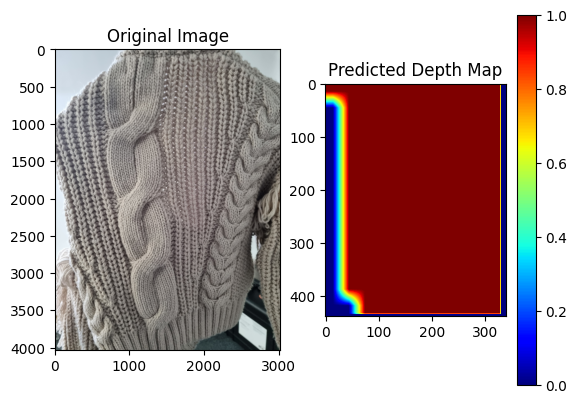

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_depth_map, cmap='jet', alpha=1)
plt.title('Predicted Depth Map')

plt.colorbar()
plt.show()